In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
linewidth = 1

list = "List"
listrev = "ListRev"
deque = "Deque"
steque = "Steque"
cadeque = "Cadeque"
cadeque2 = "Cadeque2"

clist = "#E56399"
clistrev = "#E66363"
csek = "#FBD87F"
cdeque = "#7FD1B9"
csteque = "#72A8B0"
ccadeque = "#647FA6"
ccadeque2 = "#000000"

In [ ]:
def make_time_data_2D(data, name):
    times = data[name + "T"]
    occur = data[name + "N"]
    Y = []
    for t, n in zip(times, occur):
        if n == 0:
            Y.append(0.)
        else:
            Y.append(t / n)

    X = [i for i in range(len(times))]
    return np.array(X), np.array(Y)

def plot_time_data_2D(data, name, color):
    X, Y = make_time_data_2D(data, name)
    plt.plot(X, Y, label=name, color=color, linewidth=linewidth)

def make_time_data_3D(data, name):
    times = data[name + "T"]
    occur = data[name + "N"]
    s = int (np.sqrt(len(times.to_list())))
    Z = []
    Zline = []
    for t, n in zip(times, occur):
        if n == 0:
            z = 0.
        else:
            z = t / n
        if len(Zline) == s:
            Z.append(Zline)
            Zline = [z]
        else:
            Zline.append(z)
    Z.append(Zline)

    X = [i for i in range(s)]
    Y = [i for i in range(s)]
    return np.array(X), np.array(Y), np.array(Z)

def plot_time_data_3D(data, name):
    X, Y, Z = make_time_data_3D(data, name)
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, linewidth=0)

    ax.set_zlim(0, 20)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


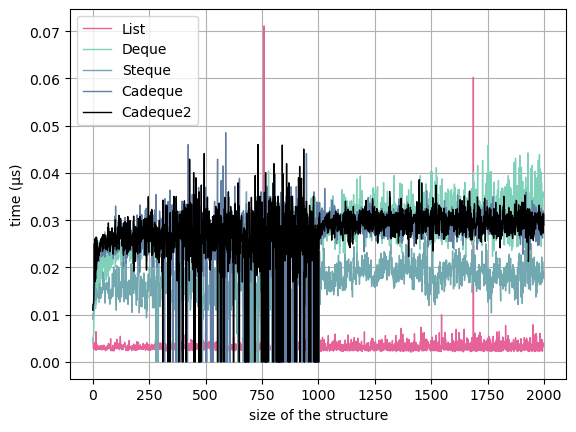

In [18]:
# Graph for push

file = "./tmp/push.csv"
data = pd.read_csv(file)

plt.plot(data["Size"], make_time_data(data, list), label=list, color=clist, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, deque), label=deque, color=cdeque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, steque), label=steque, color=csteque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque), label=cadeque, color=ccadeque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque2), label=cadeque2, color=ccadeque2, linewidth=linewidth)
plt.grid()
plt.xlabel("size of the structure")
plt.ylabel("time (µs)")
plt.legend()
plt.show()


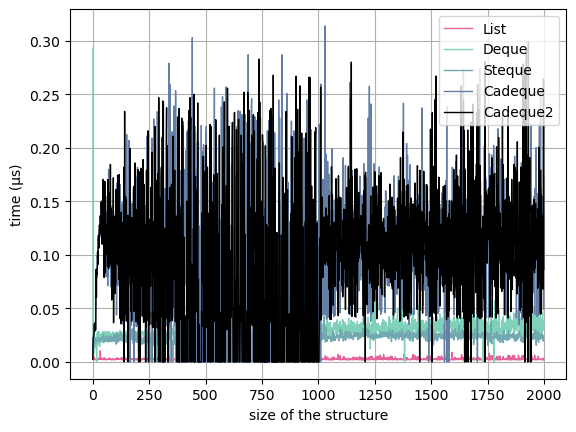

In [19]:
# Graph for pop

file = "./tmp/pop.csv"
data = pd.read_csv(file)

plt.plot(data["Size"], make_time_data(data, list), label=list, color=clist, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, deque), label=deque, color=cdeque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, steque), label=steque, color=csteque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque), label=cadeque, color=ccadeque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque2), label=cadeque2, color=ccadeque2, linewidth=linewidth)
plt.grid()
plt.xlabel("size of the structure")
plt.ylabel("time (µs)")
plt.legend()
plt.show()

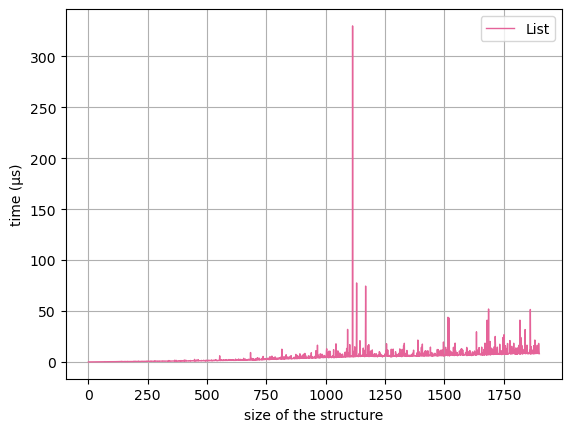

In [14]:
# Graph for inject

file = "./tmp/inject.csv"
data = pd.read_csv(file)

plot_time_data(data, list, clist)
# plt.plot(data["Size"], make_time_data(data, deque), label=deque, color=cdeque, linewidth=linewidth)
# plt.plot(data["Size"], make_time_data(data, steque), label=steque, color=csteque, linewidth=linewidth)
# plt.plot(data["Size"], make_time_data(data, cadeque), label=cadeque, color=ccadeque, linewidth=linewidth)
# plt.plot(data["Size"], make_time_data(data, cadeque2), label=cadeque2, color=ccadeque2, linewidth=linewidth)
plt.grid()
plt.xlabel("size of the structure")
plt.ylabel("time (µs)")
plt.legend()
plt.show()

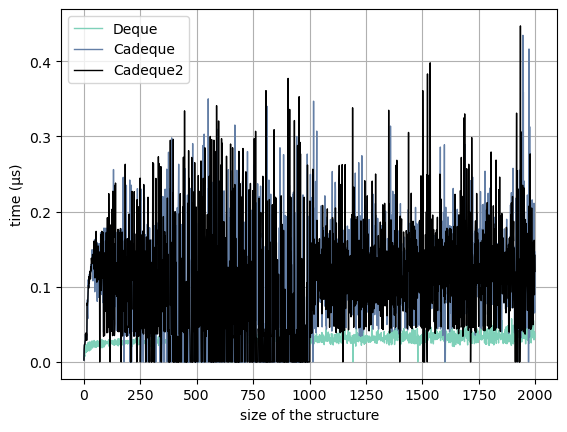

In [21]:
# Graph for eject

file = "./tmp/eject.csv"
data = pd.read_csv(file)

# plt.plot(data["Size"], make_time_data(data, list), label=list, color=clist, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, deque), label=deque, color=cdeque, linewidth=linewidth)
# plt.plot(data["Size"], make_time_data(data, steque), label=steque, color=csteque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque), label=cadeque, color=ccadeque, linewidth=linewidth)
plt.plot(data["Size"], make_time_data(data, cadeque2), label=cadeque2, color=ccadeque2, linewidth=linewidth)
plt.grid()
plt.xlabel("size of the structure")
plt.ylabel("time (µs)")
plt.legend()
plt.show()

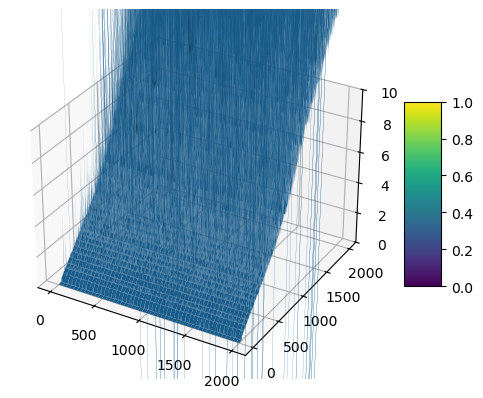

In [24]:
# Graph for concat

file = "./tmp/concat.csv"
data = pd.read_csv(file)

plot_time_data_3D(data, list)